# Linear regression for an actual data set

We consider linear regression for an actual data set. We will use simple features of pandas (see https://pandas.pydata.org/) for data analysis.

**There are 9 questions to answer.**

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# set up the random number generator: given seed for reproducibility, None otherwise
# (see https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)
my_seed = 1
rng = np.random.default_rng(seed=my_seed) 

# Dataset 

We use the "day.csv" dataset from https://archive-beta.ics.uci.edu/dataset/275/bike+sharing+dataset (download the file from this page, rename it as 'BikeSharingDataset.csv' and put it the same directory as where this file is run; see below particular instruction on google colab). This dataset records daily counts of bike rentals, together with calendar information and weather conditions. In particular, the field *cnt* gives the total number of rentals that day. This is the quantity we want to predict by linear regression. 

In [109]:
# TO IMPORT A DATA FILE ON GOOGLE COLAB; NOT TO BE USED WITH A NOTEBOOK
# see for instance https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import files
# uploaded = files.upload()

In [110]:
df = pd.read_csv('BikeSharingDataset.csv')
df.head()
df.info() # if only data types are wanted: print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### Cleaning-up and constructing the data set

We remove the first two columns (index of element in the dataset and exact date), as well as the distinction between casual and registered users as the corresponding features are not of interest to us. See https://www.kaggle.com/code/gauravduttakiit/bike-sharing-multiple-linear-regression for further checks and manipulations to ensure that the data is correct (checking for missing data, duplicates, etc).

In [111]:
# use the drop() function in panda, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# argument 'inplace=True' to permanently remove the column
df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)
df.head()
print(df.shape)

(731, 12)


For each rental day, the following features are provided:
 - season: 1=winter, 2=spring, 3=summer, 4=fall
 - yr: year, here 0 for 2011 and 1 for 2012
 - mnth: month, numbered from 1 to 12
 - holiday: 0 if no holiday, 1 if there is a holiday (extracted from http://dchr.dc.gov/page/holiday-schedule)
 - weekday: 0 (Sunday) to 6 (Saturday)
 - workingday: 0 for non-working day, 1 for working day 
 - weathersit: weather favorability rating from 1 (clear day) to 4 (rain, fog)
 - temp: normalized temperature 
 - atemp: normalized temperature feels like
 - hum: normalized humidity 
 - windspeed: normalized wind speed
 - cnt: the number of rented bicycles (target attribute to be predicted)

So, we have features which are real numbers (*temp, atemp, hum,	windspeed*), binary (*holiday, workingday*), and ordinal features (eg. *season, weekday, weathersit*). We can consider all of them as real numbers features. To get some idea of the data values, we can use the panda function *describe()*, which produces some descriptive statistics (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html).

In [112]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


Note that the *yr* data is more or less evenly distributed (as the mean is close to 0.5). On the other hand, there are only a handful of holidays (see the small mean value of *holiday*), so this variable should probably not be considered.

We next randomly split the data into train and test sets, before conducting any analysis, as such an analysis will be based on the train set only. This is done using a dedicated scikit-learn function (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [113]:
fraction_train = 0.7 
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 516 to 413
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      511 non-null    int64  
 1   yr          511 non-null    int64  
 2   mnth        511 non-null    int64  
 3   holiday     511 non-null    int64  
 4   weekday     511 non-null    int64  
 5   workingday  511 non-null    int64  
 6   weathersit  511 non-null    int64  
 7   temp        511 non-null    float64
 8   atemp       511 non-null    float64
 9   hum         511 non-null    float64
 10  windspeed   511 non-null    float64
 11  cnt         511 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 51.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 612 to 680
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      220 non-null    int64  
 1   yr          220 non-null    int64  
 2   mn

### Exploring the data

We start by exploring the dataset to understand how the target attribute (*cnt*) depends on each of the features. We start by using the plot function of *pandas* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html). It would be better to do this on the training data only, but we do it on the full data here.

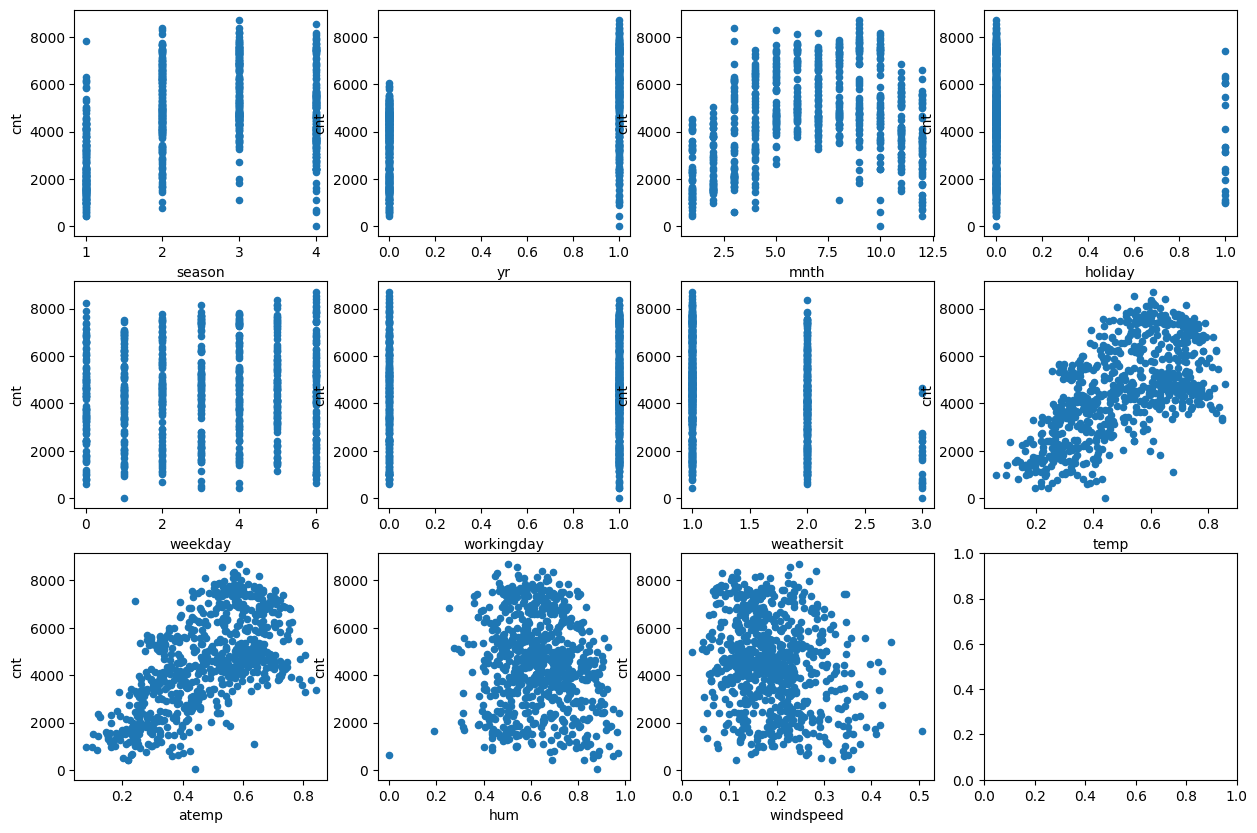

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
# df_train.columns[:-1] is the list of all columns, except the last one (the target attribute 'cnt')
# this can be enumerated with an index using https://docs.python.org/3/library/functions.html#enumerate
# position in the axes: vector [i,j] with i is the line number, and j the column index
for idx, feature in enumerate(df_train.columns[:-1]):
    df.plot(feature, "cnt", subplots=True,  kind="scatter", ax=axes[idx // 4, idx % 4]) 
plt.show()

It is not so easy to have some quantitative impression from scatter plots of categorical variables. Boxplots can be more appropriate.

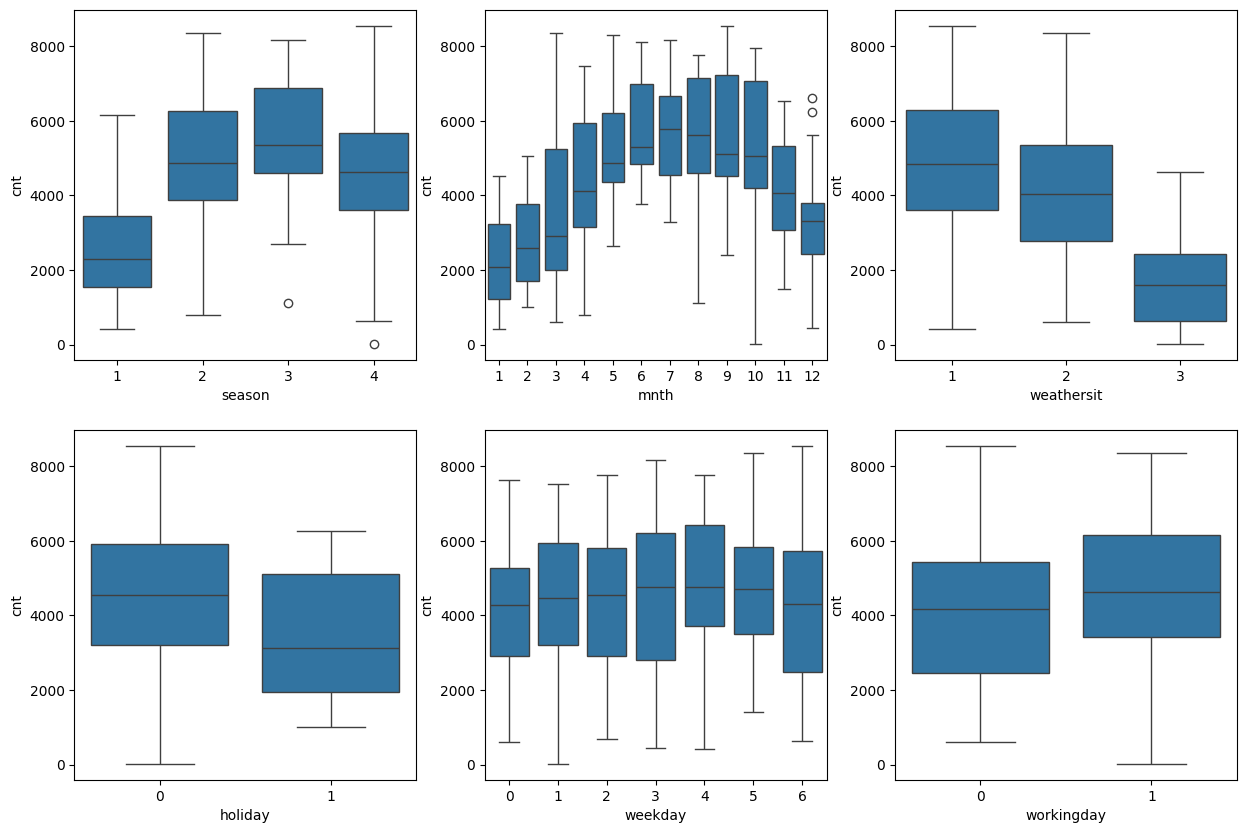

In [115]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_train)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_train)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_train)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_train)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_train)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_train)
plt.show()

**Question 1.** Based on these plots, describe features which have an influence on the target attribute.

Based on these plots, we can see that the features **season**, **mnth**, **holiday**, **weathersit**, **temp** and **atemp** have an important influence on the target attribute. Indeed, more bikes are rented in the spring and the summer and when this is a clear day. Moreover, in average, during the no holyday period, more bikes are rented. This could be explained by the fact that people can move from one place to another by bike in the week (to go to their work office for example). 
The feature **year** has also an influence on the count of total rental bikes because we can see that has increased from 2011 to 2012.

We can notice that **weekday** and **workingday** don't have a real influence because on average the count of total rental bikes is always the same around 4300.

### Data normalization

The sizes of the data entries are on rather different scales, as made precise through the output of the *describe()* function above. We therefore renormalize the data by rescaling the features, so that all entries are between 0 and 1 (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [116]:
scaler = MinMaxScaler()
df_train[:] = scaler.fit_transform(df_train[:])
df_train.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.500978,0.500978,0.497776,0.033268,0.493151,0.679061,0.200587,0.543472,0.520096,0.647371,0.349601,0.520571
std,0.368636,0.500489,0.310916,0.179512,0.335786,0.467295,0.277205,0.227086,0.213833,0.147352,0.164857,0.225914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.272727,0.000000,0.166667,0.000000,0.000000,0.351016,0.340357,0.543916,0.233986,0.362592
50%,0.333333,1.000000,0.454545,0.000000,0.500000,1.000000,0.000000,0.543115,0.536771,0.652100,0.326911,0.526075
75%,0.666667,1.000000,0.727273,0.000000,0.833333,1.000000,0.500000,0.740406,0.694243,0.750000,0.434605,0.688093
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The minimum and maximum are indeed 0 and 1 for all variables.

### Features and target correlations

We now estimate more quantitatively the level of linear dependence between the features and the target variable. A good measure of the linear relationship between two vectors is the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (see also Chapter 25 [Shalev-Shwartz] for a discussion on how it relates to feature selection). 

Correlations can also be computed with the *pandas* library, using the dataframe method *corr* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html), and plotted with the heatmap function of the statistical data visualization library *seaborn* (see https://seaborn.pydata.org/generated/seaborn.heatmap.html)/ 

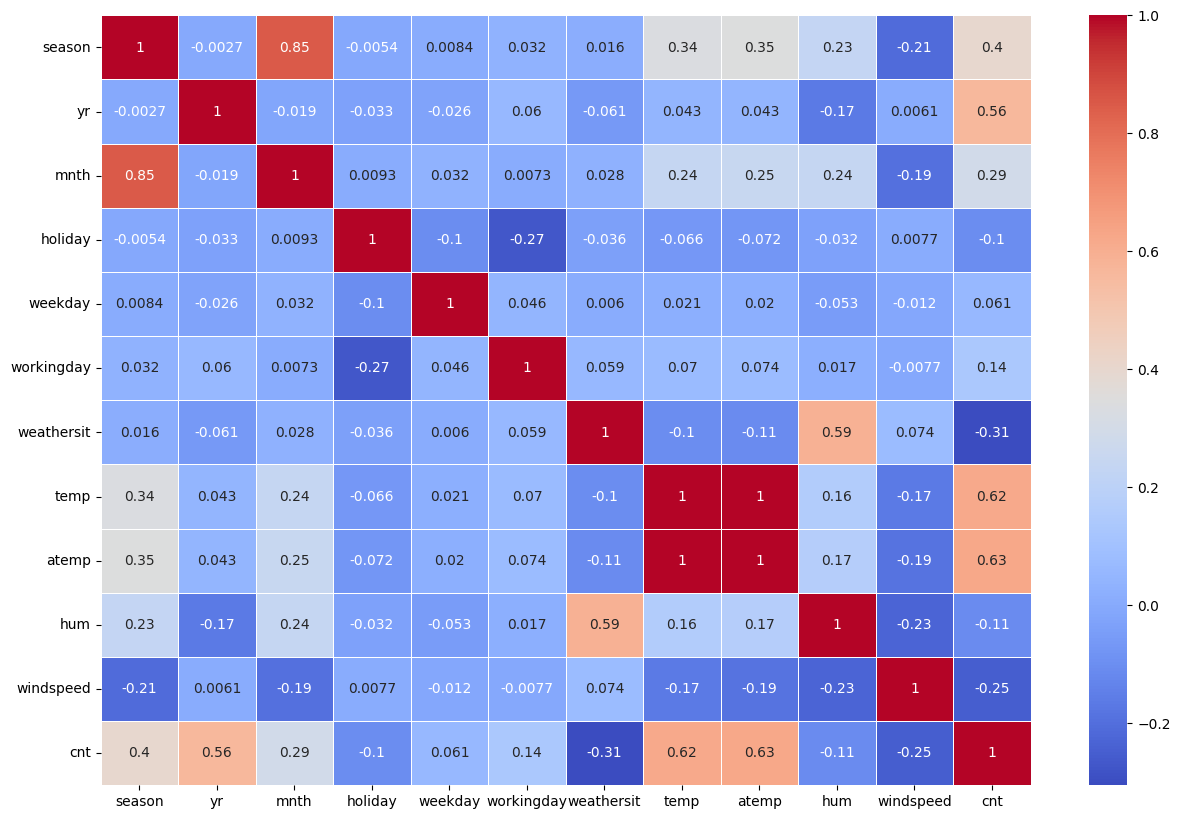

In [117]:
plt.figure(figsize = (15,10))
# sns.set_theme()
# other 'Diverging colormaps' can be used, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
sns.heatmap(df_train.corr(method='pearson'), annot = True, linewidths=.5, cmap="coolwarm")
plt.show()

We next break down the correlations into correlations between the variables we are looking for to predict the result, and correlations between these variables and the target attribute *cnt*. The latter correlations can be computed with the function *corrwith* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html), which needs as argument another dataframe as an argument to compute the pairwise correlations with. 

In [118]:
# df_train_variables is df_train without the column of the target attribute 'cnt'
# alternative command: use df[df.columns.difference(['cnt'])]
df_train_variables = df_train[df_train.columns[:-1]]
# get features correlation coefficients
df_train_variables.corr(method='pearson')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
season,1.000000,-0.002662,0.849566,-0.005431,0.008415,0.032180,0.015665,0.336816,0.346717,0.231255,-0.211344
yr,-0.002662,1.000000,-0.019173,-0.033100,-0.026212,0.060032,-0.061483,0.043132,0.042743,-0.166683,0.006064
mnth,0.849566,-0.019173,1.000000,0.009313,0.032152,0.007347,0.028453,0.239843,0.247826,0.239522,-0.193861
holiday,-0.005431,-0.033100,0.009313,1.000000,-0.104643,-0.269838,-0.035857,-0.066334,-0.071630,-0.032007,0.007722
weekday,0.008415,-0.026212,0.032152,-0.104643,1.000000,0.046361,0.006012,0.021057,0.019988,-0.053436,-0.011846
workingday,0.032180,0.060032,0.007347,-0.269838,0.046361,1.000000,0.058978,0.069787,0.073531,0.017110,-0.007676
weathersit,0.015665,-0.061483,0.028453,-0.035857,0.006012,0.058978,1.000000,-0.103034,-0.106638,0.589993,0.073995
temp,0.336816,0.043132,0.239843,-0.066334,0.021057,0.069787,-0.103034,1.000000,0.996669,0.162681,-0.165581
atemp,0.346717,0.042743,0.247826,-0.071630,0.019988,0.073531,-0.106638,0.996669,1.000000,0.170224,-0.186806
hum,0.231255,-0.166683,0.239522,-0.032007,-0.053436,0.017110,0.589993,0.162681,0.170224,1.000000,-0.231430


Some quantities are strongly correlated (in particular *temp* and *atemp*). This will require some care when choosing the features for prediction.

We next compute correlations with the target attribute. 

In [119]:
df_train_variables.corrwith(df_train['cnt'], axis=0, method='pearson')

season        0.398915
yr            0.562776
mnth          0.290522
holiday      -0.103542
weekday       0.061110
workingday    0.136656
weathersit   -0.305070
temp          0.618621
atemp         0.625290
hum          -0.110008
windspeed    -0.251013
dtype: float64

**Question 2.** Compare these numbers with the corresponding ones in the heatmap above.

These numbers corresponds exactly to the ones on the last column of the heatmap (or the last line) because *corrwith* computes the correlations with **cnt**.

The sample above shows features correlations with the target. Some of them (in fact, all of  them) are not *null*. This means that it makes sense to try to predict the output using a linear method (although in the end it may not be sufficient).

# Training with all features (despite strong correlations)

Some attributes in our dataset have strong correlations (one speaks of *multicollinearity*, see https://en.wikipedia.org/wiki/Multicollinearity), which can lead to issues in solving the regression problem, as the design matrix may be ill-conditioned. We start by a naive estimation where we pretend that we have not noticed the strong correlations, in order to highlight the kind of problems that arise.

We start by decomposing the train data into the features $X$ and the target attribute $y$.

In [120]:
# from sklearn.utils import shuffle
# df_shuffled = shuffle(df, random_state=123)
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
df_test[:] = scaler.transform(df_test[:]) 
X_test = df_test[df_test.columns[:-1]]
y_test = df_test["cnt"]
print(X.head())
print('\n------------------------------------\n')
print(y.head())

       season  yr      mnth  holiday   weekday  workingday  weathersit  \
70   0.000000   0  0.181818        0  1.000000           0         0.0   
58   0.000000   0  0.090909        0  0.166667           1         0.5   
102  0.333333   0  0.272727        0  0.500000           1         0.5   
582  0.666667   1  0.636364        0  0.000000           0         0.0   
75   0.000000   0  0.181818        0  0.666667           1         0.0   

         temp     atemp       hum  windspeed  
70   0.341803  0.323801  0.611396   0.408978  
58   0.440666  0.421419  0.901146   0.551041  
102  0.447283  0.443951  0.842331   0.470498  
582  0.898739  0.855850  0.670951   0.552557  
75   0.450447  0.434828  0.619966   0.385896  

------------------------------------

70     0.242752
58     0.163829
102    0.246203
582    0.626093
75     0.313162
Name: cnt, dtype: float64


**Question 3.** Check that the test data has been properly normalized. Are the minima and maxima of all features 0 and 1, respectively? If not, why? 

In [121]:
X_test.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,220.000000,220.00000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.516667,0.50000,0.519421,0.022727,0.518939,0.677273,0.202273,0.547478,0.513926,0.653005,0.339407
std,0.374511,0.50114,0.319614,0.149373,0.336016,0.468586,0.255075,0.226366,0.206919,0.139565,0.158170
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107865,0.092512,0.320051,0.047441
25%,0.333333,0.00000,0.272727,0.000000,0.166667,0.000000,0.000000,0.360262,0.345255,0.550021,0.221469
50%,0.666667,0.50000,0.545455,0.000000,0.500000,1.000000,0.000000,0.538523,0.511500,0.659812,0.324355
75%,1.000000,1.00000,0.818182,0.000000,0.833333,1.000000,0.500000,0.738936,0.679119,0.760283,0.425959
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.015822,0.952767,0.966134,0.824380


No, the data has not been well normalized because for **atemp**, **hum** and **windspeed**, the min and max are not 0 and 1. We can notice that the maximum of **atemp** is greater than 1. This can be explained by the fact that this feature has been scaled through the line of code ```df_test[:] = scaler.transform(df_test[:])``` but the scaler has been fit on the *train data* beforehand but the maximum and the minimum of the *train data* were not the max/min of the whole dataset so there were a value greater than the max of the *train data* in the *test data*. Same reason for **hum** and **windspeed**.

### Plain training of a linear model

We first do some training on the whole data set, with all features kept.

**Question 4.** Train a linear regression model on the training dataset and look at the feature weights. The acquired weights are in the *coef_* parameter of a regressor class. It is good to re-run the estimation several times by randomly re-splitting the data set into train and test sets. What do you observe?

In [122]:
from sklearn import linear_model
# build a model
linear_regressor = linear_model.LinearRegression() 
# train the model using all data
linear_regressor.fit(X, y) 
# output coefficients
print('\nCoefficients and their weights:')
# zip function to aggregate https://docs.python.org/3.3/library/functions.html#zip
# "{:.3f}".format(number) to display number with 3 decimal places
# or alternatively round(number,3), as used below
for pair in zip(df_train.columns, linear_regressor.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1])) 


Coefficients and their weights:
season  ->  0.175
yr  ->  0.233
mnth  ->  -0.064
holiday  ->  -0.046
weekday  ->  0.055
workingday  ->  0.009
weathersit  ->  -0.148
temp  ->  -0.182
atemp  ->  0.731
hum  ->  -0.117
windspeed  ->  -0.135


By re-running the estimation several times, we can notice that the values can vary a lot for example for **season**, it can vary from 0.143 to 0.189. But in general, the weights stay in the same order of magnitude.

For the remainder of this notebook, we remove the *temp* field, and only keep *atemp*.

In [123]:
df.drop('temp',axis=1,inplace=True)

# Training with some regularization 
We next consider training with some regularization in order to obtain the best bias/variance trade-off. The norm of weights multiplied by the regularization coefficient $\alpha$ is added to the cost function to minimize. We consider both lasso ($\ell^1$ norm) and ridge ($\ell^2$ norm) regression. We train the associated regularized cost functions with their defaults parameters, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html and https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [124]:
from sklearn.linear_model import Lasso, Ridge

### One shot training

We can run the optimization with lasso and ridge regression various times, by randomly reshuffling the data set in order to get some intuition on the variability of the coefficients. We work here only on the training data, and do not test yet the quality of the prediction on the test set.

**Question 5.** Change the value of the regularization parameter $\alpha$ in order to see the impact on the fitted coefficients. What do you observe?

In [212]:
lasso = Lasso(alpha=0.0001)
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
lasso.fit(X, y)
print('Intercept -> ', round(lasso.intercept_,3))
for pair in zip(df_train.columns, lasso.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1])) 

Intercept ->  0.129
season  ->  0.192
yr  ->  0.256
mnth  ->  -0.040
holiday  ->  -0.082
weekday  ->  0.047
workingday  ->  0.006
weathersit  ->  -0.160
atemp  ->  0.552
hum  ->  -0.107
windspeed  ->  -0.119


When the regularization parameter $\alpha$ is large (eg. 0.1), the fitted coefficients are all null. If we reduce by 2 the value of $\alpha$, we notice that the weight for the year has became 0.052 but all the other weights are still null. With $\alpha$ = 0.01 we obtain better results but we still have some null coefficients. Then from $\alpha$ = 0.001, we begin to have satisfying results but it is even better with $\alpha$ = 0.0001. With $\alpha$ < 0.0001, we obtain the same results.

**Question 6.** Do the same for ridge regression.

In [253]:
ridge = Ridge(alpha=0.1)
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
ridge.fit(X, y)
print('Intercept -> ', round(ridge.intercept_,3))
for pair in zip(df_train.columns, ridge.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1])) 

Intercept ->  0.196
season  ->  0.172
yr  ->  0.228
mnth  ->  -0.047
holiday  ->  -0.072
weekday  ->  0.048
workingday  ->  0.011
weathersit  ->  -0.147
atemp  ->  0.505
hum  ->  -0.135
windspeed  ->  -0.103


Whatever the value of $\alpha$, the fitted coefficients vary and behave the same. Contrary to the Lasso regression, we can take $\alpha$ = 0.1. However, from $\alpha$ = 1000, the weights become almost null.

### Training paths

We now explore more systematically the dependence of the result as a function of the regularization coefficient. The aim is to find the best value of $\alpha$ for prediction, using the test set. Before doing this, we look more closely at how the coefficients of the fit change as $\alpha$ is increased.

For each coefficient value from the vector of values *alphas_lasso* for the parameter $\alpha$, we train the Lasso regressor and write the weights into the corresponding rows of the *coefs_lasso* matrix. The same is then done for ridge regression. This will allow us to look at how coefficients vary as $\alpha$ is changed. Note that it would be possible instead to plot results as a function of the magnitude of the coefficients, using the scikit-learn function https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lars_path.html

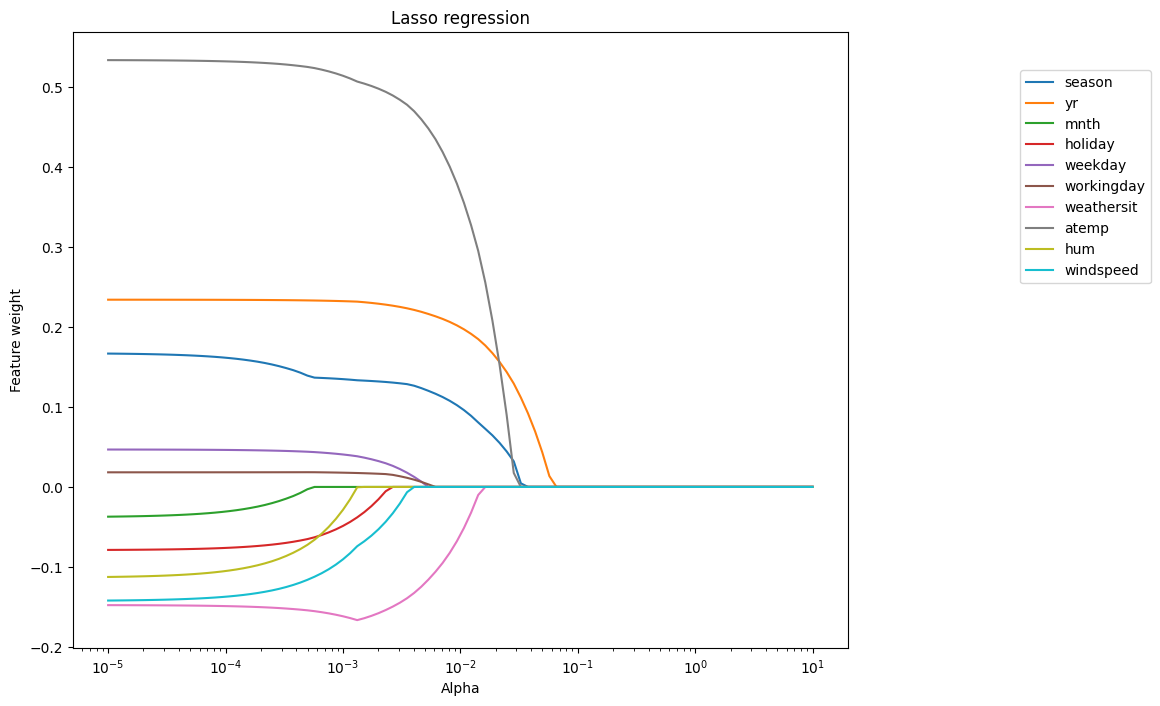

In [127]:
# we use coefficients logarithmically spaced in order to cover a wide range of values 
alphas_lasso = np.logspace(-5, 1, 100)
coefs_lasso = np.zeros((alphas_lasso.shape[0], X.shape[1])) 

for i, al in enumerate(alphas_lasso):
    lasso = Lasso(alpha = al)
    lasso.fit(X, y)
    for j, coef in enumerate(lasso.coef_):
        coefs_lasso[i][j] = coef
        
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.semilogx(alphas_lasso, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Lasso regression")
plt.show()

We next do the same for ridge regression.

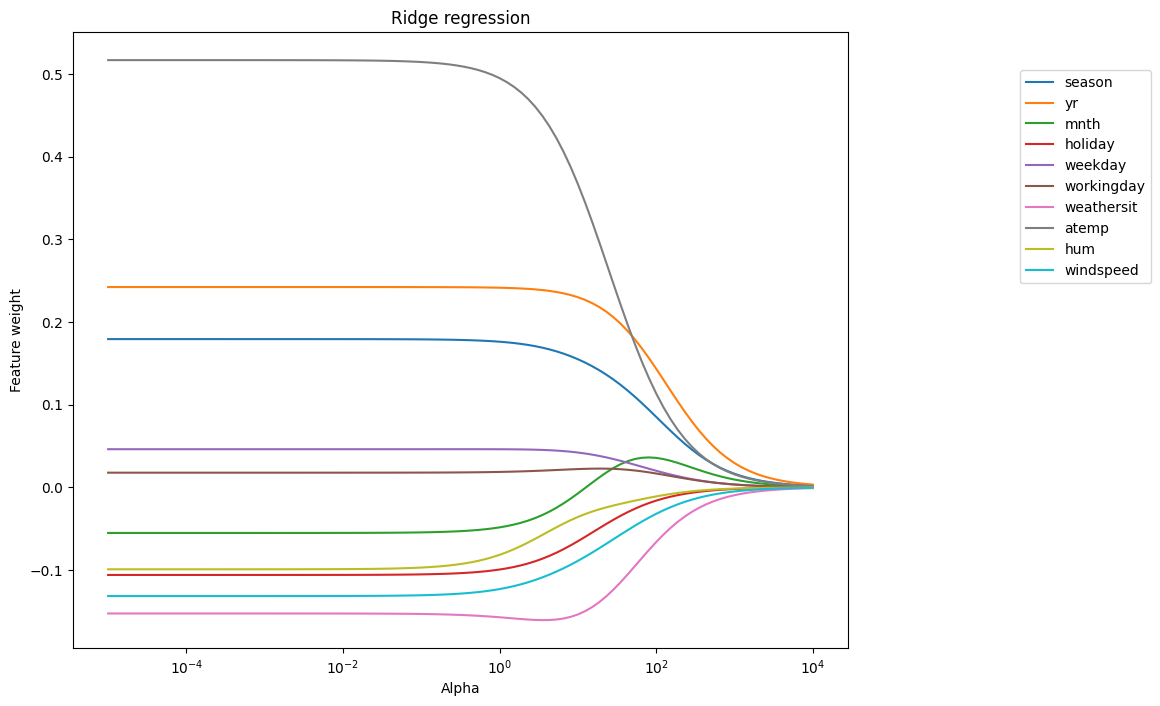

In [248]:
alphas_ridge = np.logspace(-5, 4, 100)
coefs_ridge = np.zeros((alphas_ridge.shape[0], X.shape[1]))

for i, al in enumerate(alphas_ridge):
    ridge = Ridge(alpha = al)
    ridge.fit(X, y)
    for j, coef in enumerate(ridge.coef_):
        coefs_ridge[i][j] = coef
        
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.semilogx(alphas_ridge, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Ridge regression")
plt.show()

For illustration, we can also compute the regression path as a function of the magnitude of the coefficients, for lasso.

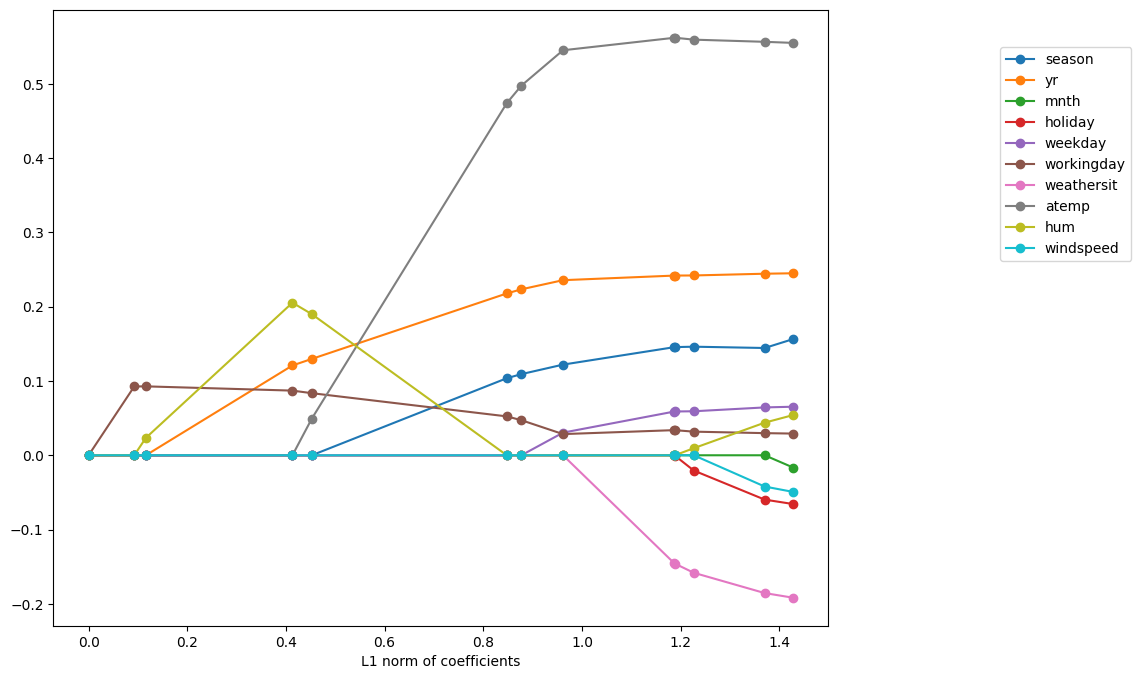

In [129]:
# dataframes need to be converted to numpy format
XX = X.to_numpy()
yy = y.to_numpy()
_, _, coefs = linear_model.lars_path(XX, yy, method="lasso")

# plot the corresponding result
tau = np.sum(np.abs(coefs.T), axis=1)
plt.figure(figsize=(10, 8))
plt.xlabel("L1 norm of coefficients")
plt.plot(tau, coefs.T, marker="o")
plt.legend(list(df.columns), bbox_to_anchor=(1.4, 0.95))
plt.show()

**Question 7.** What are the largest coefficients? Which coefficients are the most important? (in the sense that they are non zero first when performing lasso)

The largest coefficients and the most important are **atemp**, **year** and **month** with respectively $0,51$, $0,24$ and $0,18$.

Another important coefficients is **weathersit** and **windspeed**.

In [130]:
df_0 = df[df["yr"] == 0]
df_1 = df[df["yr"] == 1]
print('Statistics for the first year \n')
print(df_0.describe())
print('\n ------------------------------ \n')
print('Statistics for the second year \n')
print(df_1.describe())

Statistics for the first year 

           season     yr        mnth     holiday     weekday  workingday  \
count  365.000000  365.0  365.000000  365.000000  365.000000  365.000000   
mean     2.498630    0.0    6.526027    0.027397    3.008219    0.684932   
std      1.110946    0.0    3.452584    0.163462    2.006155    0.465181   
min      1.000000    0.0    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.0    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.0    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    0.0   10.000000    0.000000    5.000000    1.000000   
max      4.000000    0.0   12.000000    1.000000    6.000000    1.000000   

       weathersit       atemp         hum   windspeed          cnt  
count  365.000000  365.000000  365.000000  365.000000   365.000000  
mean     1.421918    0.466835    0.643665    0.191403  3405.761644  
std      0.571831    0.168836    0.148744    0.076890  1378.753666  
min    

### Cross validation

We next perform cross validation in order to choose the best coefficient. The metric for the quality of the results is the mean square error (MSE) computed on the test set. We explore two approaches: randomly splitting the full data set into test/train sets, or using k-fold cross validation. For the latter method, we use built-in routines in scikit-lean to divide the sample into $k$ blocks, each of them being considered as a test set when training is performed on the remaining $k-1$ blocks. The MSE for a given value of $\alpha$ is averaged over the test MSEs over the folds. 

We start by computing the MSE and the regression score for a given value of $\alpha$ in a pedestrian way, in order to get a feeling for what is being done. Everything is done for Lasso, but the adaptation to ridge regression would be straightforward.

**Question 8.** Complete the code below: in one case, you need to compute 'by hand' something computed by a built-in scikit-learn function, and in the other case you need on the contrary to use a built-in scikit-learn function (see the comments "TO COMPLETE" below).

In [254]:
from sklearn.metrics import mean_squared_error

Intercept: 0.11941057560414964
Rounded coef: [0.196, 0.249, -0.066, -0.061, 0.036, 0.016, -0.141, 0.539, -0.073, -0.125]

R2  (train) =  0.7935914593533935
R2  (train) =  0.7935914593533935  computed by hand
MSE (train) =  0.011660118820773504 442    0.671802
385    0.105990
402    0.484841
130    0.461055
317    0.498521
         ...   
85     0.154301
16     0.068893
726    0.206187
597    0.750431
397    0.409169
Name: cnt, Length: 511, dtype: float64
MSE (train) =  0.011660118820773504  computed by hand

R2   (test) =  0.8063557593094373
MSE  (test) =  0.011206132191562006


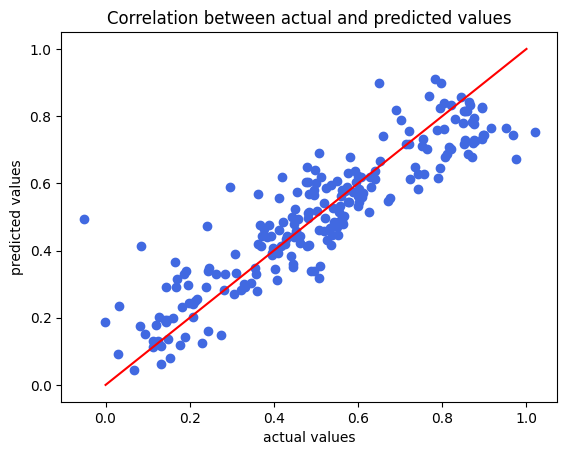

In [255]:
al = 0.0001

df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
df_test[:] = scaler.transform(df_test[:])
X_test = df_test[df_test.columns[:-1]]
y_test = df_test["cnt"]

lasso = Lasso(alpha = al)
lasso.fit(X, y)
# report coefficients
print('Intercept:', lasso.intercept_)
print( 'Rounded coef:', list(map(lambda c: round(c, 3) , lasso.coef_) )) 
# see function score() on https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
print('\nR2  (train) = ',lasso.score(X,y))
y_pred = lasso.predict(X)
u = ((y - y_pred)** 2).sum()
v = ((y - y.mean()) ** 2).sum()
R2_computed_manually = 1 - (u/v)
print('R2  (train) = ',R2_computed_manually,' computed by hand')
# we next compute the MSE 
MSE_computed_with_scikitlearn = mean_squared_error(y, lasso.predict(X))
print('MSE (train) = ',MSE_computed_with_scikitlearn, y)
print('MSE (train) = ',((y-lasso.predict(X))**2).mean(),' computed by hand\n')
# compute the prediction error on the test set
# one can check that this is equivalent to lasso.intercept_+sum(lasso.coef_*X[i]) for each index i  
y_pred = lasso.predict(X_test)
print('R2   (test) = ',lasso.score(X_test,y_test))
print('MSE  (test) = ',((y_test-y_pred)**2).mean())
# plotting the results
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We now more precisely quantify the variability of the outputs by performing several realizations.

In [256]:
al = 0.0001
nb_real = 100

R2_test = np.zeros(nb_real) 
MSE_test = np.zeros(nb_real)

lasso = Lasso(alpha = al)
for real in range(nb_real):
  df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
  df_train[:] = scaler.fit_transform(df_train[:])
  X_train = df_train[df_train.columns[:-1]]
  y_train = df_train["cnt"]
  lasso.fit(X, y)
  df_test[:] = scaler.transform(df_test[:])
  X_test = df_test[df_test.columns[:-1]]
  y_test = df_test["cnt"]
  R2_test[real] = lasso.score(X_test,y_test)
  # equivalently one could use a built-in function: 
  # import function as --> from sklearn.metrics import mean_squared_error 
  # call function as --> mean_squared_error(y_pred, y)
  # with y_pred = lasso.predict(X)
  MSE_test[real] = ((y_test-lasso.predict(X_test))**2).mean() 
    
print('Average R2  (test) =', R2_test.mean())
print('Average MSE (test) =', MSE_test.mean())

Average R2  (test) = 0.7866035954668925
Average MSE (test) = 0.011001813110228766


In practice, one rather uses a single data set, and relies on built-in cross validation function such as [__LassoCV__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It takes as input a list of values of $\alpha$ and calculates the MSE for each of them. After training, the regressor will contain the variable __mse\_path\___, a matrix of size `len(alpha) x n_folds`, where `n_folds` (the number of blocks in cross-validation), containing the MSE values on the test for the corresponding runs. In addition, the variable __alpha\___ will store the selected (optimal) value of the regularization parameter, and in __coef\___, will have the trained weights corresponding to this __alpha___.

Note that the regressor can change the order in which it iterates through the alphas values. In order to map it to the MSE matrix, it is better to use the regressor variable __alphas___.

In [257]:
from sklearn.linear_model import LassoCV

In [258]:
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X_train = df_train[df_train.columns[:-1]]
y_train = df_train["cnt"]

alphas_lasso = np.logspace(-7, -3, 500)
nb_folds = 10
reg = LassoCV(cv=nb_folds, alphas = alphas_lasso)
reg.fit(X, y)
print('Regularizator score (R2 coefficient):', reg.score(X, y))
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')  
[(pair[0], round(pair[1], 4)) for pair in zip(df.columns[:-1], reg.coef_)]

Regularizator score (R2 coefficient): 0.7936298256551553
Regularizator's optimal alpha value: 3.28877428582551e-05
Regularizator coefficients:


[('season', 0.1989),
 ('yr', 0.2492),
 ('mnth', -0.0688),
 ('holiday', -0.0632),
 ('weekday', 0.0366),
 ('workingday', 0.0161),
 ('weathersit', -0.1403),
 ('atemp', 0.5395),
 ('hum', -0.0777),
 ('windspeed', -0.1285)]

We can plot the MSE as a function of $\alpha$ to check how much is gained in the cross validation process.

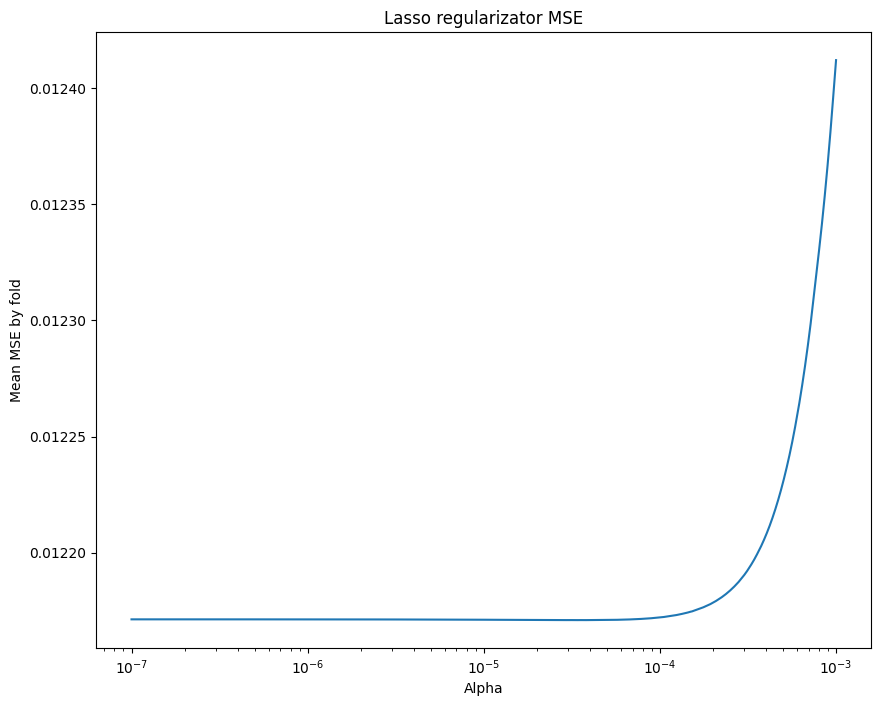

In [259]:
mean_mse_arr = np.array(reg.mse_path_).mean(axis=1)
plt.figure(figsize=(10, 8)) 
plt.semilogx(reg.alphas_, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Lasso regularizator MSE")
plt.show()

In [260]:
# use cross validation for ridge regression 
# see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
from sklearn.linear_model import RidgeCV

In [261]:
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X_train = df_train[df_train.columns[:-1]]
y_train = df_train["cnt"]

alphas_ridge = np.logspace(-5, 1, 500)
# doing "leave one out cross validation" by default 
reg = RidgeCV(cv=None, alphas = alphas_ridge, scoring=None, store_cv_values=True)
reg.fit(X, y)
print('Regularizator score (R2 coefficient):', reg.score(X, y))
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')  
[(pair[0], round(pair[1], 4)) for pair in zip(df.columns[:-1], reg.coef_)]

Regularizator score (R2 coefficient): 0.7935405453968732
Regularizator's optimal alpha value: 0.41422324724838977
Regularizator coefficients:


[('season', 0.1981),
 ('yr', 0.2488),
 ('mnth', -0.0666),
 ('holiday', -0.0629),
 ('weekday', 0.0363),
 ('workingday', 0.0167),
 ('weathersit', -0.1415),
 ('atemp', 0.5305),
 ('hum', -0.0739),
 ('windspeed', -0.1268)]

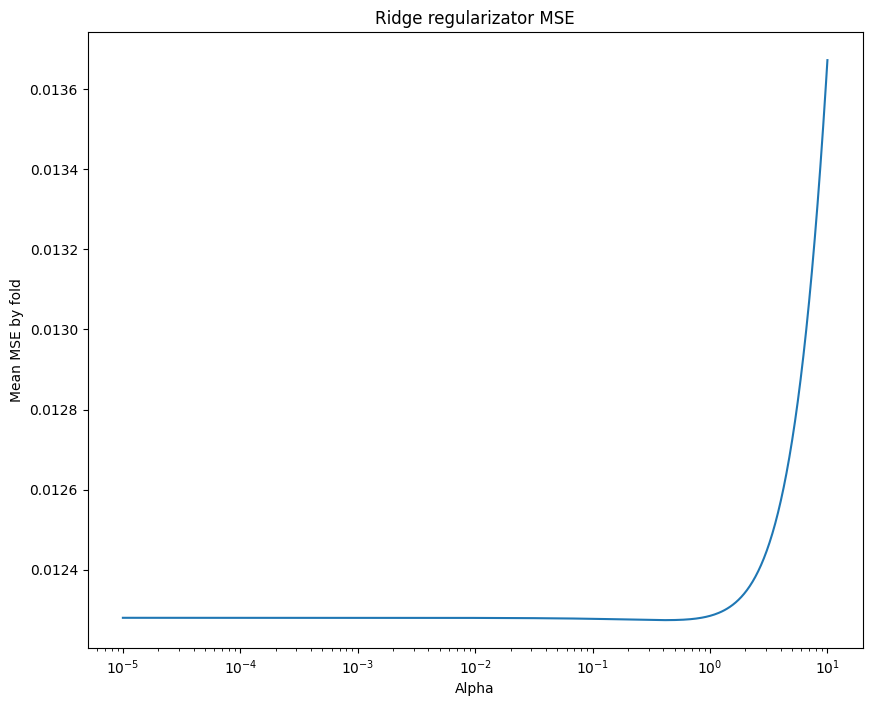

In [262]:
mean_mse_arr = np.array(reg.cv_values_).mean(axis=0)
plt.figure(figsize=(10, 8)) 
plt.semilogx(alphas_ridge, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Ridge regularizator MSE")
plt.show()

**Question 9.** What do you conclude?

To conclude, the top 5 predictor features that influences the count of the total rental bikes are:

* The temperature feels like (**atemp**) : a coefficient value of $0.5305$ indicated that a unit increase in **atemp** variable increases the bike hire numbers by 0.5636 units.

* Year (**yr**) : a coefficient value of $0.2488$ indicated that a unit increase in **yr** variable increases the bike hire numbers by 0.2308 units.

* The Season (**season**) : a coefficient value of $0.1981$ indicated that a unit increase in **season** variable increases the bike hire numbers by 0.1981 units.

* The weather situation (**weathersit**) : a coefficient value of $-0.1415$ indicated that a unit increase in **weathersit** variable decreases the bike hire numbers by -0.1415 units.

* The windspeed (**windspeed**) : a coefficient value of $-0.1268$ indicated that a unit increase in **windspeed** variable decreases the bike hire numbers by -0.1268 units.